# Introduction

A part of my work consists of acquiring the signal induced on a set of copper strips of a gaseous detectors. The signals dynamics such as the height, shape, duration, typically give useful information about what is going on inside the detector. The signal generated by a gasesous detector depends on several factors: 
- he geometry, layout and working principle of the detector itself; 
- the electric field applied in the gas medium that allows for the electron created by an ionizing particle to start an avalanche process and move a sufficiently high number of electrons to be detected by the electronics; 
- the gas used, which greatly affects the dynamic of the avalanche development

Among all of these parameters, I would like to focus on one: the time over threshold. The time over threshold can be defined in different ways. For simplicity, I will define it as the difference of the time between the signal first and last crosses a fixed treshold.

For example, look at the plot @fig-waveforms

In [25]:
#| code-fold: true

# The holy trininty of libraries that will be used
# throughout the post
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Just to set the maximum of items to be printed for an array
np.set_printoptions(threshold=5)

# A better style for plots
plt.style.use('https://gitlab.cern.ch/-/snippets/2223/raw/master/rpcecogas.mplstyle')

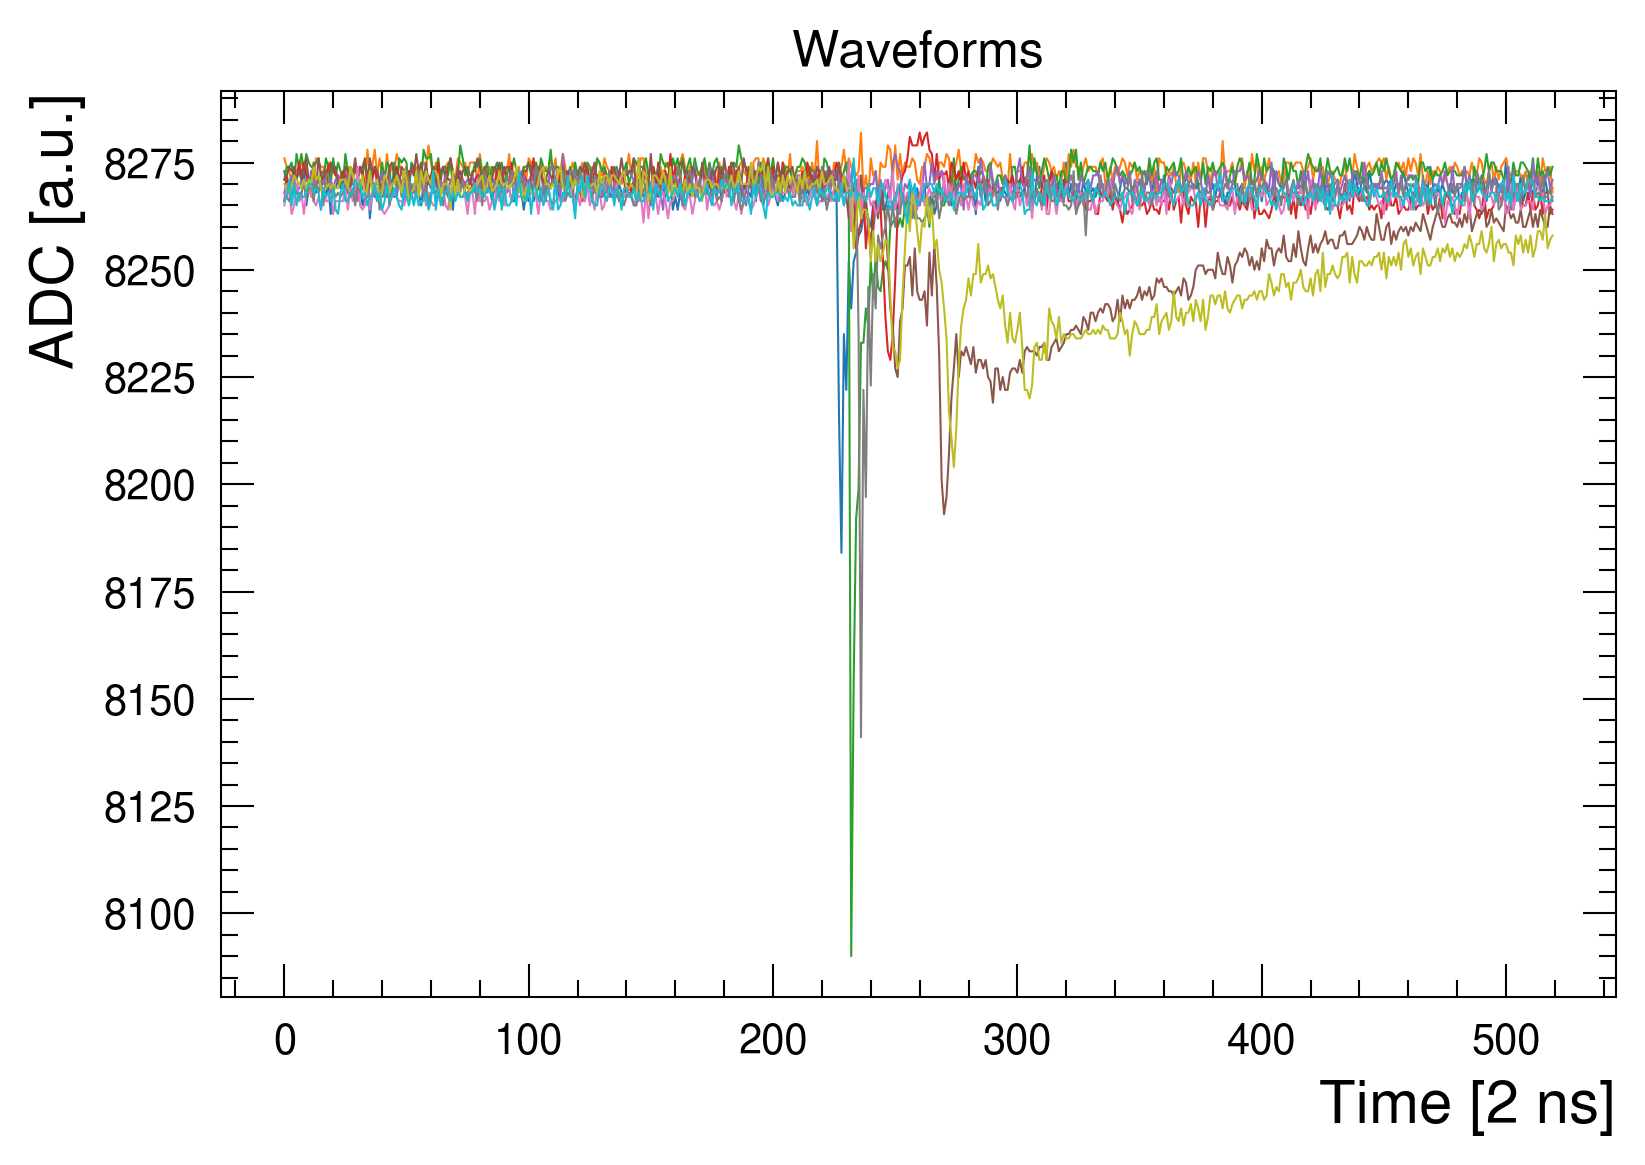

In [8]:
#| code-fold: true
#| fig-cap: "Waveform read-out from a gaseous detector"
#| label: fig-waveforms
window_length = 520
# This file contains 10 waveforms of 520 samples. Each sample is written on a single line
df = pd.read_csv("https://gist.githubusercontent.com/grigolet/09ffada96abb2acf0fe34070f0e83211/raw/3880aa89e4b113ea2866ec8e3768c03e98f84118/signals.txt",
                header=None, names=['waveform'])
# in the next line I will transform the dataframe into a 2d
# numpy array with shape (number of signals, window length).
waveforms = df.waveform.values.reshape((-1, window_length))

fig, ax = plt.subplots()
ax.plot(waveforms.T);
ax.set(xlabel='Time [2 ns]', ylabel='ADC [a.u.]', title='Waveforms');


Image that we would like to compute the duration of all the signals below a threshold that I arbitrarly fix. For example:

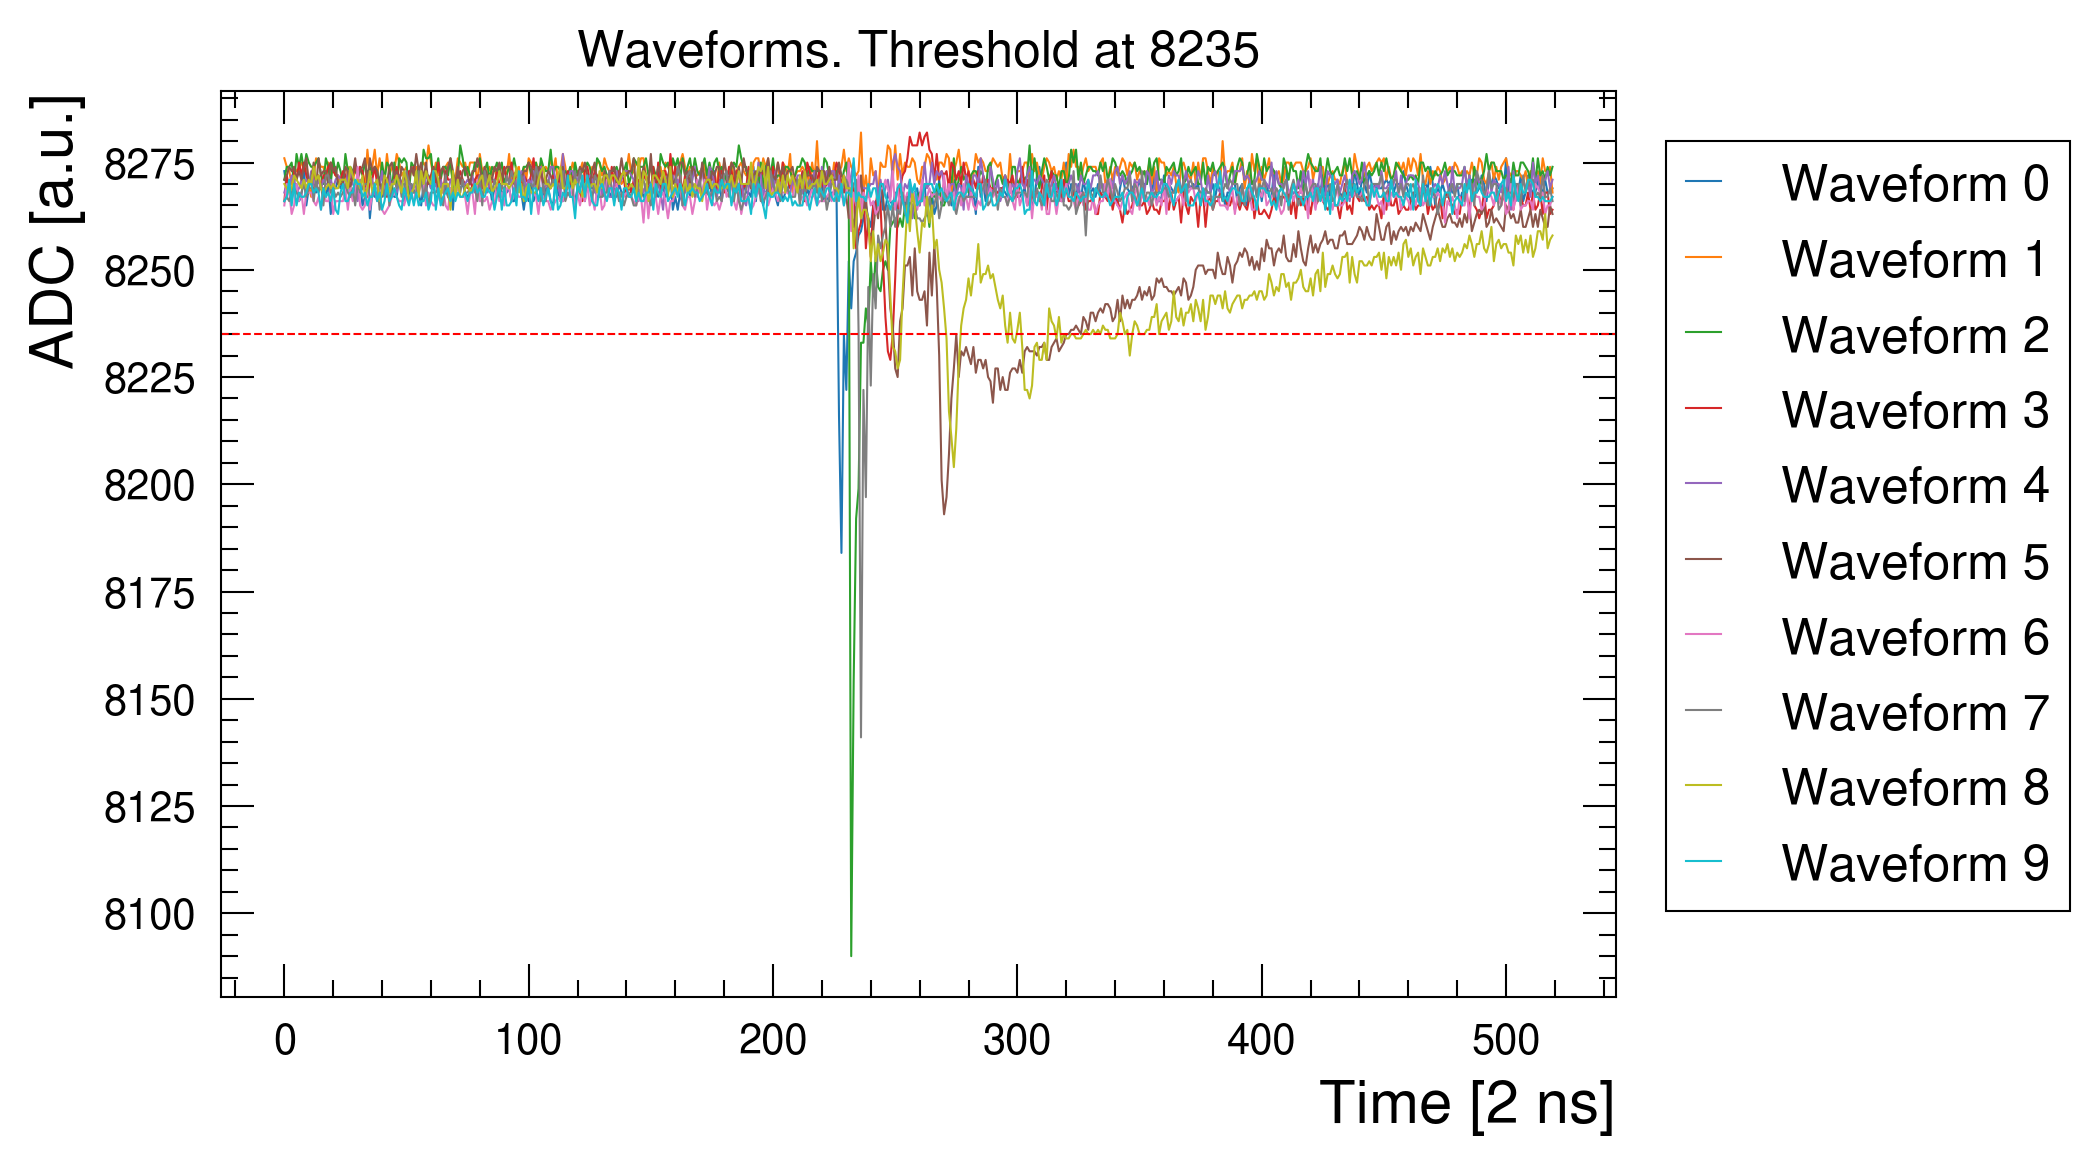

In [201]:
#| code-fold: true

# Prepare and read the data
window_length = 520
threshold = 8235
# This file contains 10 waveforms of 520 samples. Each sample is written on a single line
df = pd.read_csv("https://gist.githubusercontent.com/grigolet/09ffada96abb2acf0fe34070f0e83211/raw/3880aa89e4b113ea2866ec8e3768c03e98f84118/signals.txt",
                header=None, names=['waveform'])
# in the next line I will transform the dataframe into a 2d
# numpy array with shape (number of signals, window length).
waveforms = df.waveform.values.reshape((-1, window_length))

fig, ax = plt.subplots()
for ix, waveform in enumerate(waveforms):
    ax.plot(waveform, label=f"Waveform {ix}")
ax.axhline(threshold, color='r', linestyle='--')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set(xlabel='Time [2 ns]', ylabel='ADC [a.u.]', title=f'Waveforms. Threshold at {threshold}');

# ToT by taking the closest samples 

## The 1d case

In this case, the easiest and probably more natual approach to compute the ToT would be to get the first sample below the threshold, the last sample below the threshold and do a difference.

This is fairly straightforward in the case of a single signal and it can be accomplished in few different ways:

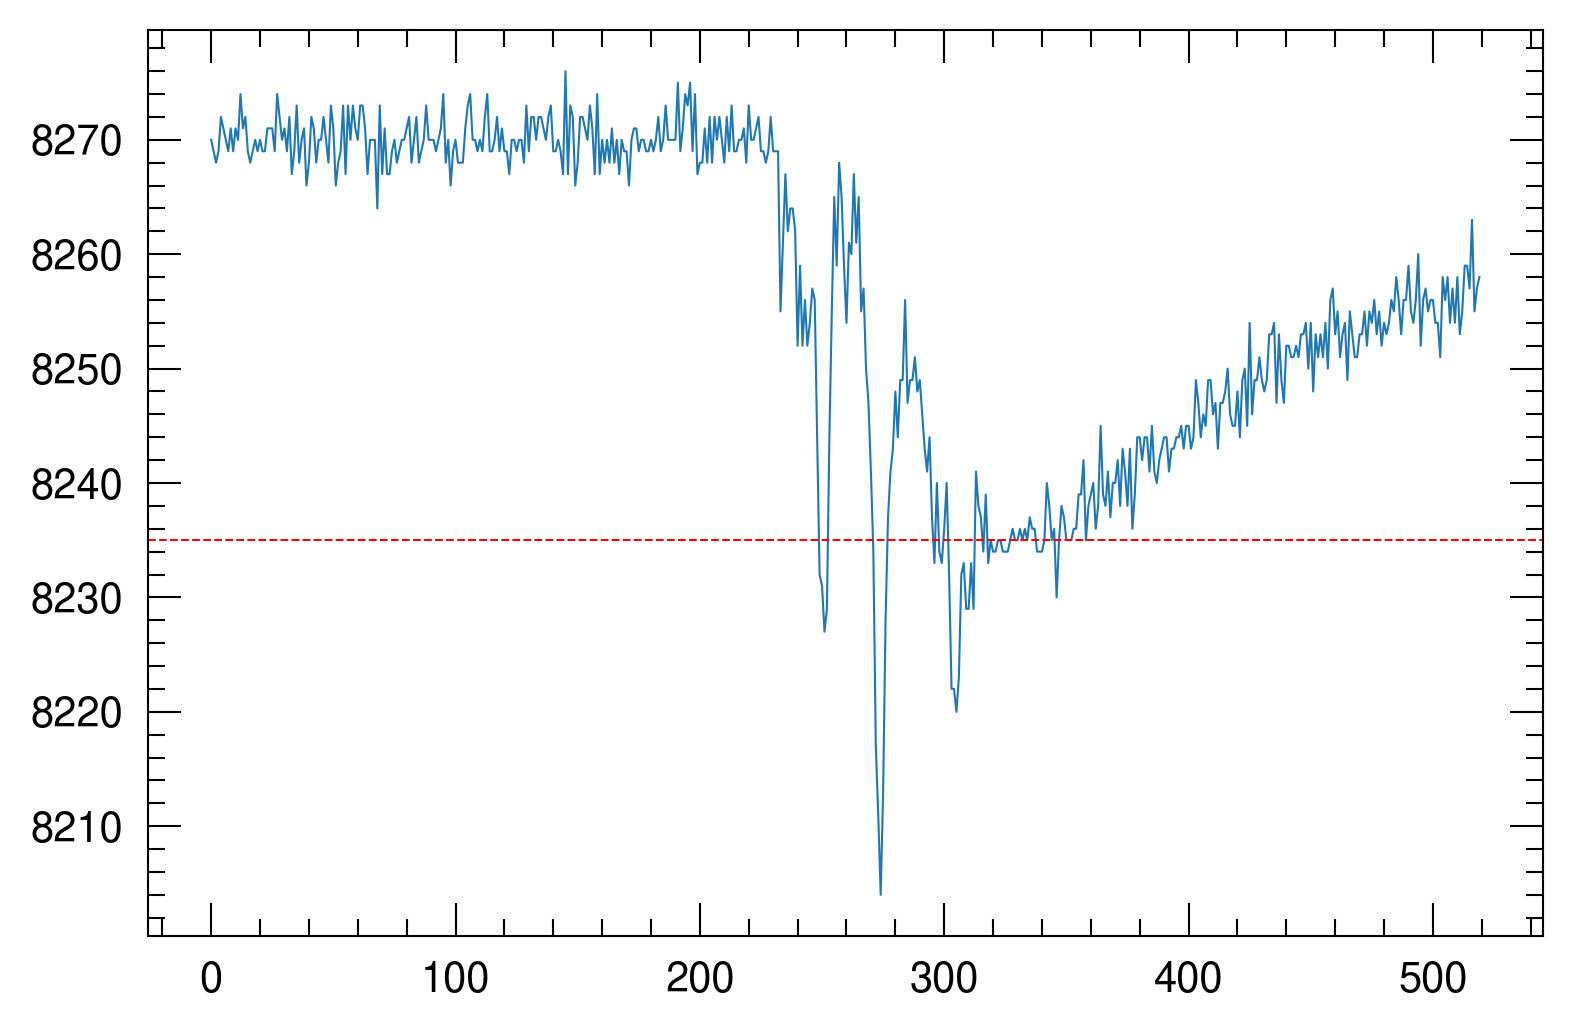

In [40]:
#| code-fold: true
# From the previous cell we have waveforms available in a 2d
# numpy array of shape (n waveforms, n samples)
# I will take waveform 8 just for example purposes

threshold = 8235
waveform = waveforms[8, :]
fig, ax = plt.subplots()
ax.plot(waveform)
ax.axhline(threshold, color='r', linestyle='--')


For the way I defined the time over threshold, I would have to take the first sample before crossing the threshold  and the last one before going back

In [41]:
samples_below_threshold = waveform < threshold
# Boolean array indicating which sample is below the threshold
samples_below_threshold

array([False, False, False, ..., False, False, False])

If I imagine the boolean array defined above as an integer array, I could use `np.argmax()` to find the first item for which the condition is true, i.e. the first item crossing the threshold.

To find instead the last item I could use `np.argmax()` but applied to the reversed array, taking into account that the resulting index should be then subtracted with the number of samples of the waveform


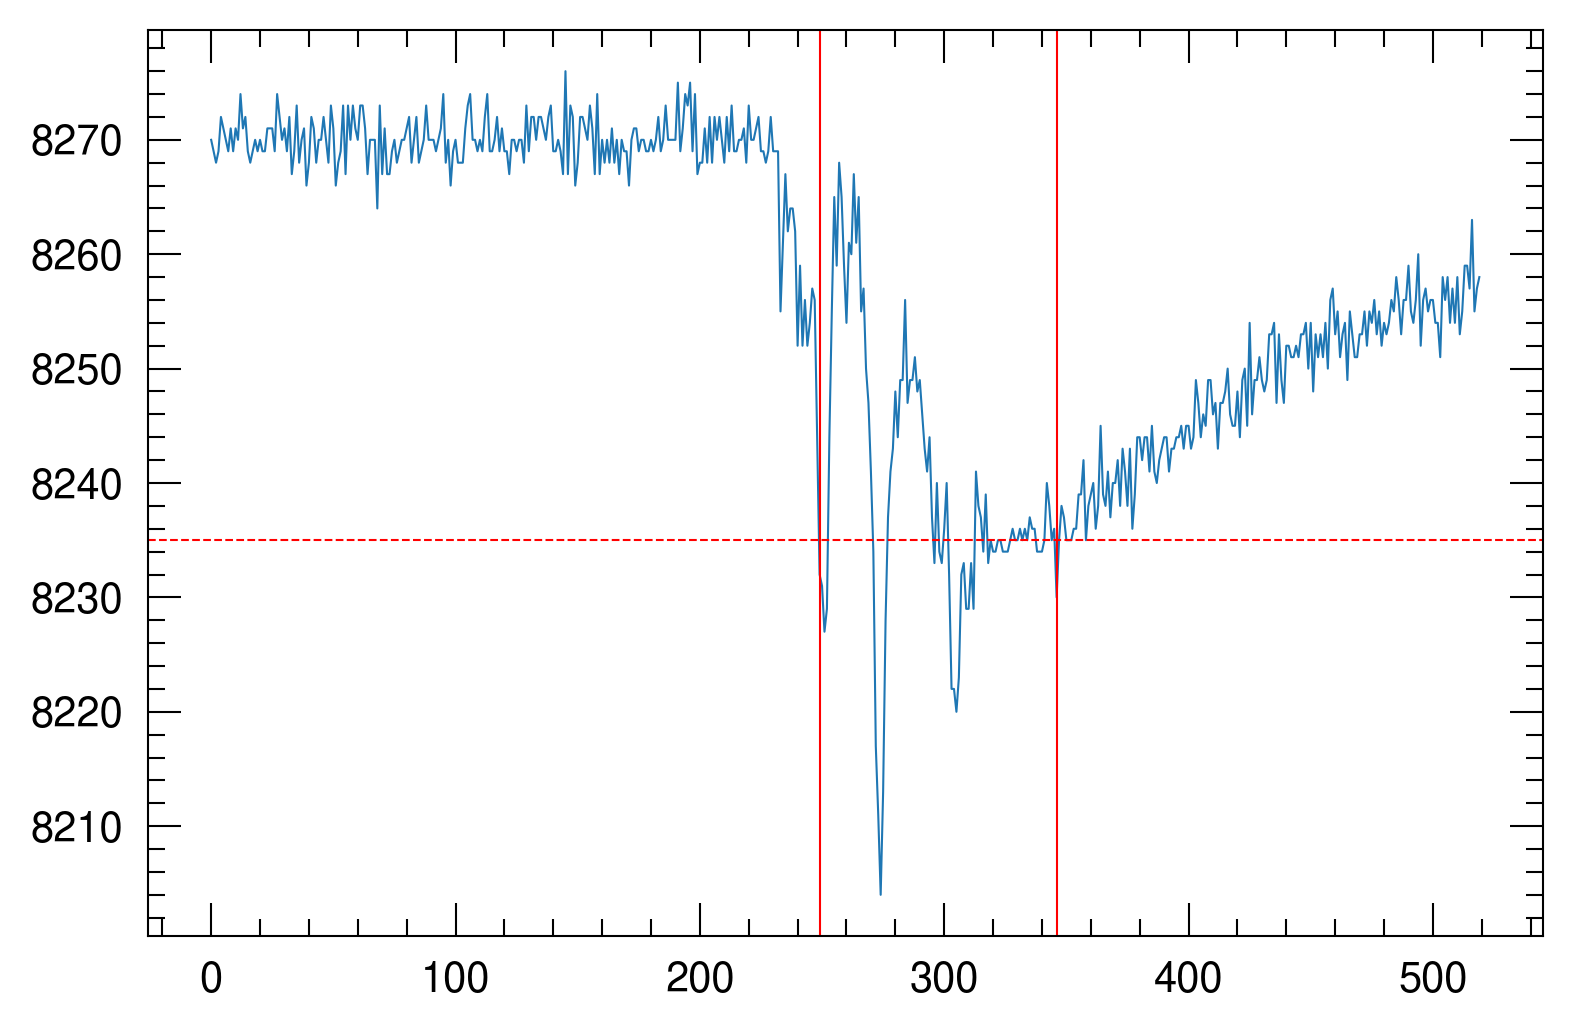

In [42]:
first_item = np.argmax(samples_below_threshold)
last_item = window_length - np.argmax(samples_below_threshold[::-1]) -1
first_item, last_item

fig, ax = plt.subplots()
ax.plot(waveform)
ax.axhline(threshold, color='r', linestyle='--')
ax.axvline(first_item, color='r')
ax.axvline(last_item, color='r')

## The 2d case

In a case of a 2d array like `waveforms`, some numpy gym can be used to perform vectorized operation and avoid using `for` loops. 

A trick I often used to remember on which axis I want to perform an operation on a `numpy.ndarray`: if the numpy array has a shape (x_dim, y_dim, z_dim, ...) then the operation I perform the aggregation on is making that axis collapse.

So in the present case, if I have an `(n_waveforms, n_samples)` array, then I would expect to have the `argmax()` of each waveform, so an array with a shape `(n_waveforms)`. This means that `axis=0` should be preversed and `axis=1` should collapse, so the `np.argmax()` operation should have `axis=1`. 

It's a bit tricky but it's working fine in my mental model

[227   0 232 ... 236 249   0] [230 519 237 ... 240 346 519]


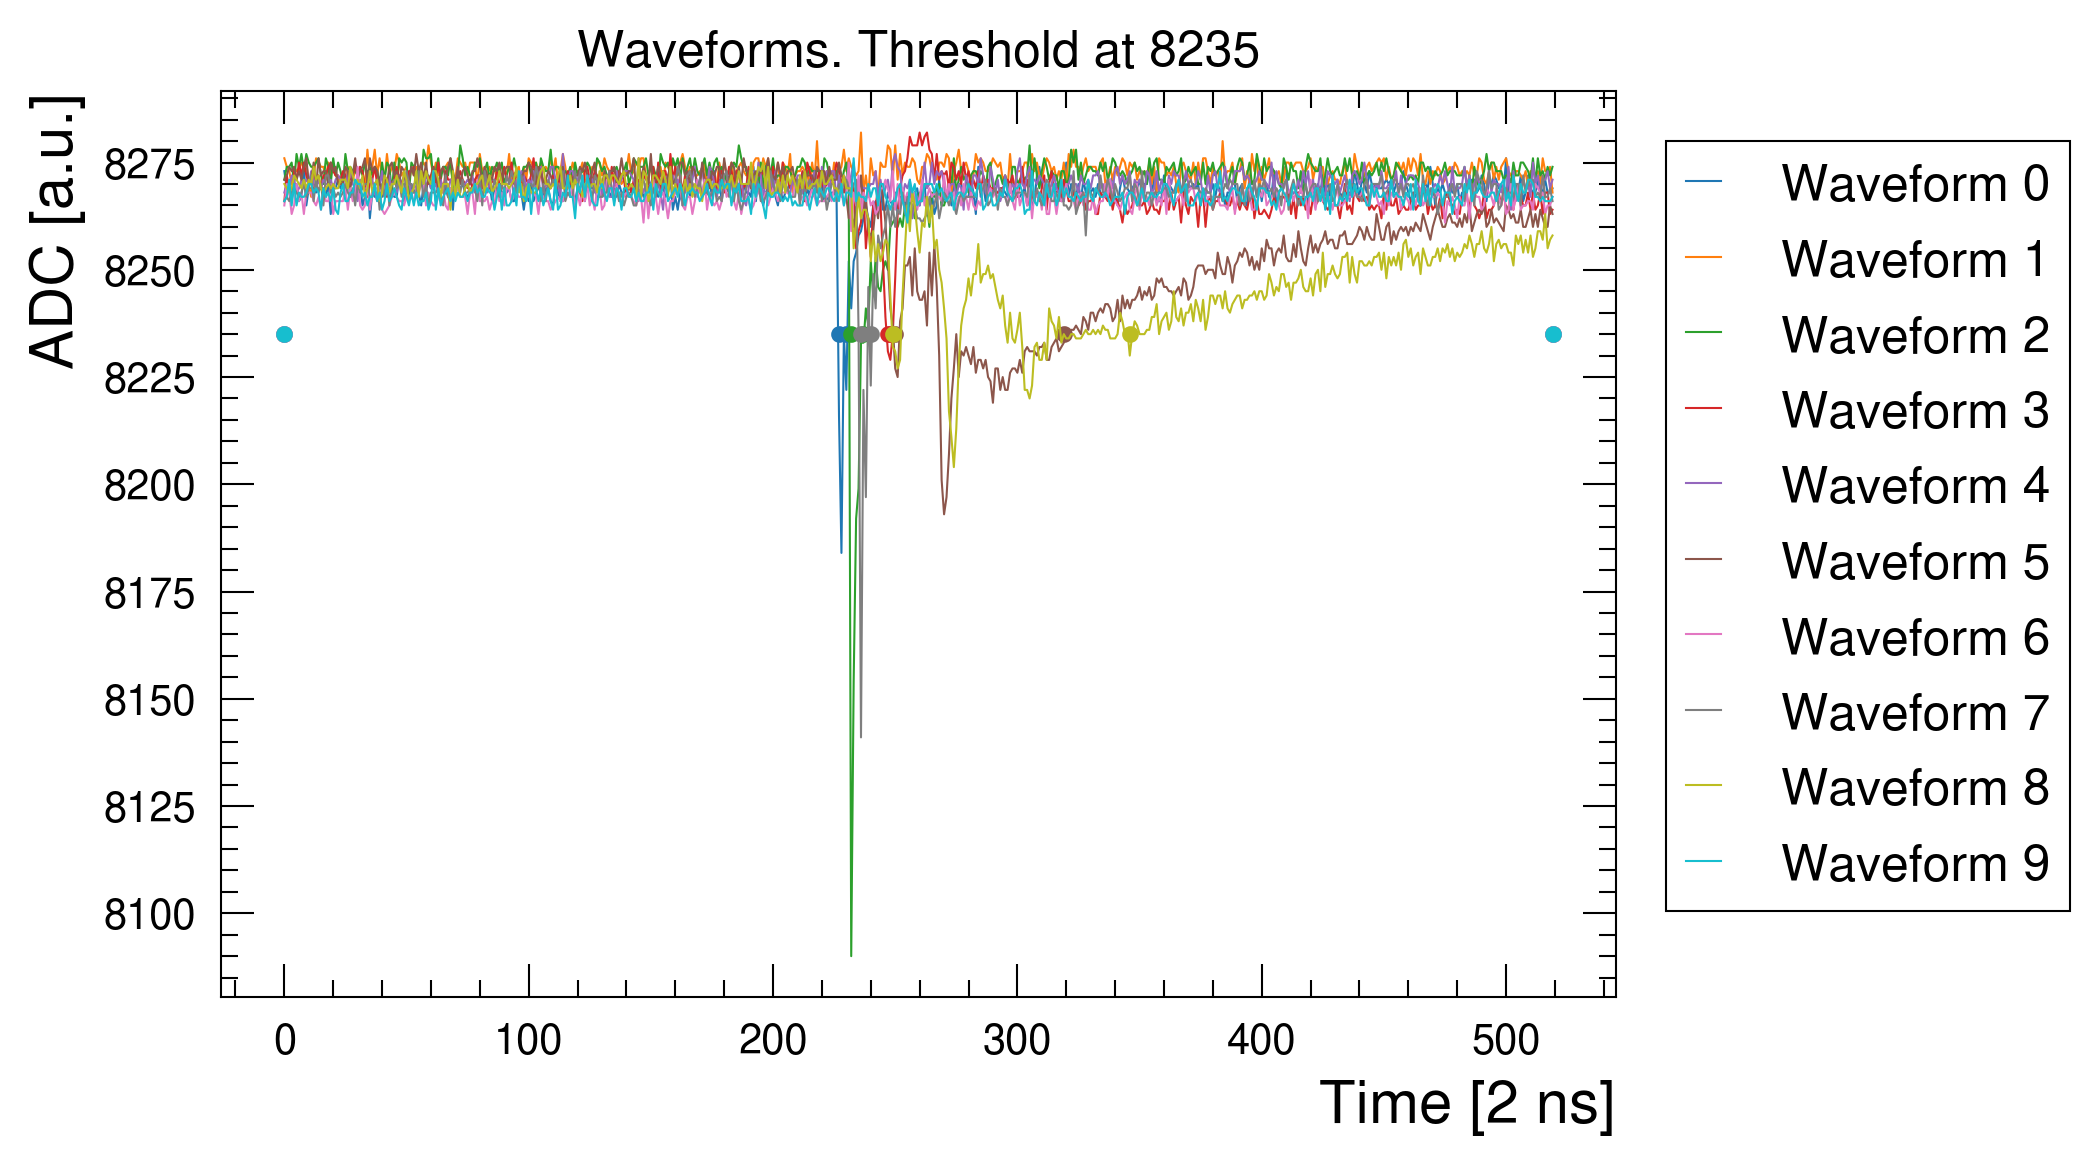

In [63]:
samples_below_threshold = waveforms < threshold
# Now we have a 2d array of waveforms but
# an analogue boolean mask
samples_below_threshold

first_items = np.argmax(samples_below_threshold, axis=1)
# Reverse the array over the samples dimensions to get the last 
# point of threshold crossing
last_items = window_length - np.argmax(samples_below_threshold[:, ::-1], axis=1) - 1

print(first_items, last_items)

# Let's graphically check the results
fig, ax = plt.subplots()
for ix, waveform in enumerate(waveforms):
    ax.plot(waveform, label=f"Waveform {ix}")
    ax.plot(first_items[ix], threshold, f'C{ix}.')
    ax.plot(last_items[ix], threshold, f'C{ix}.')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set(xlabel='Time [2 ns]', ylabel='ADC [a.u.]', title=f'Waveforms. Threshold at {threshold}');


In the example above I marked the points at which the threshold is crossed. However, in the case of a waveform not crossing the threshold, the `np.argmax()` function would return 0, so `first_item` would be equal to 0 and `last_item` would be equal to `window_length - 1`, as it is for the 9th waveform:

0 519


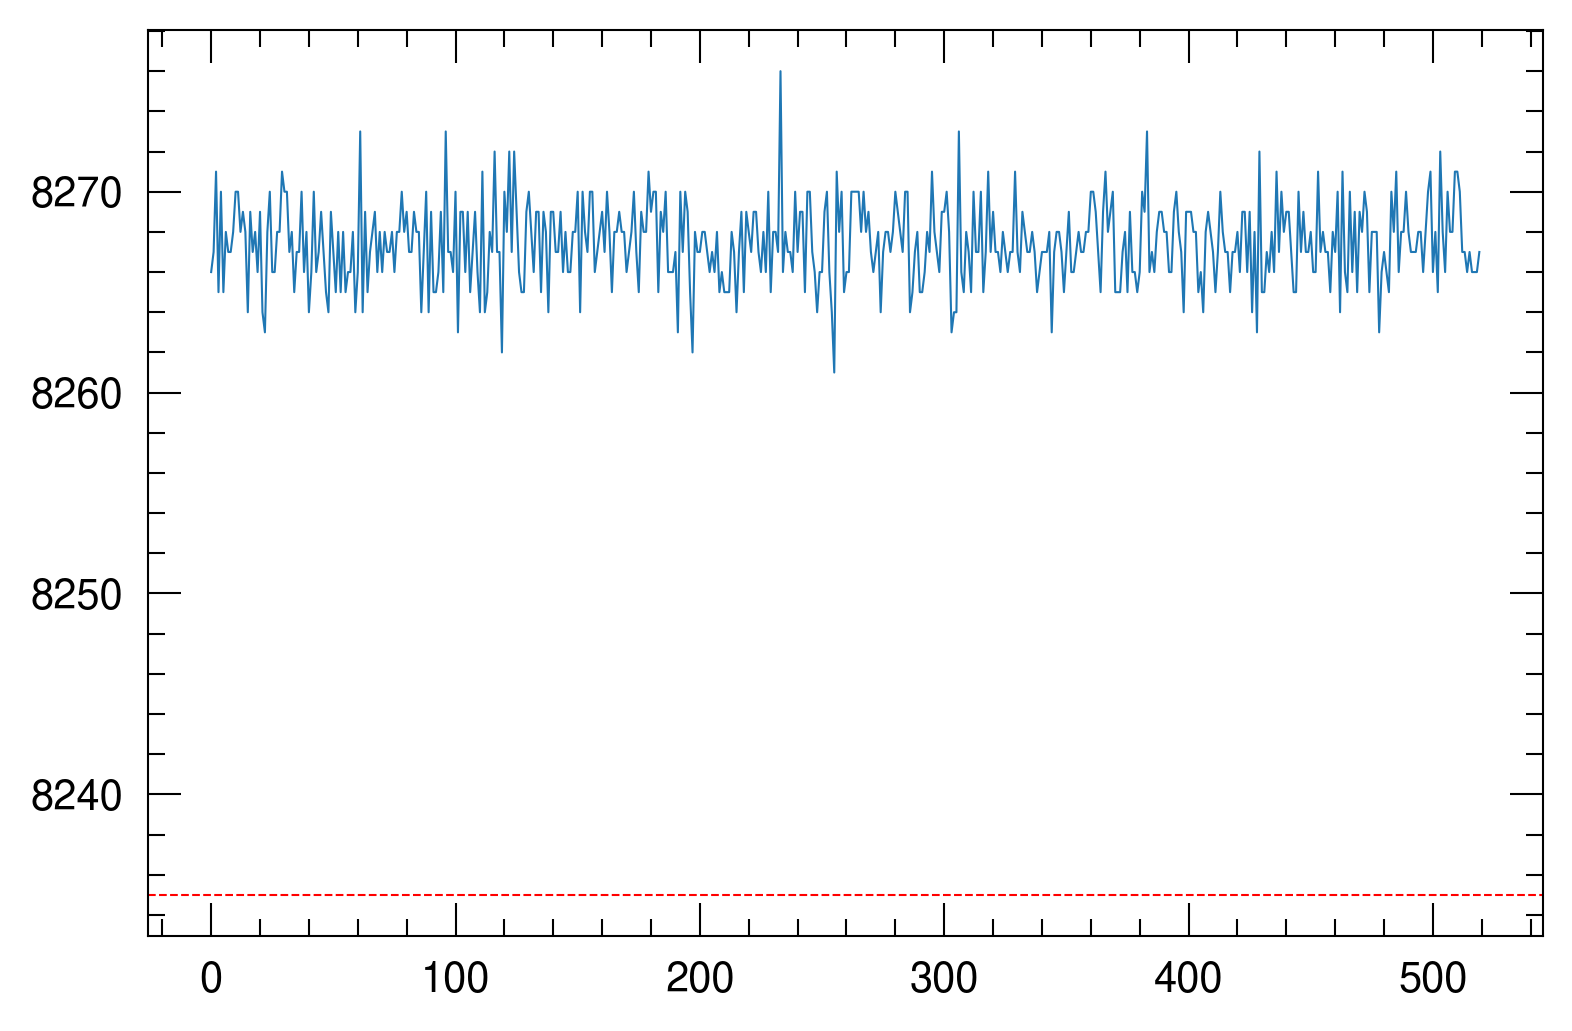

In [66]:
n_waveform = 9
waveform = waveforms[n_waveform, :]
fig, ax = plt.subplots()

print(first_items[n_waveform], last_items[n_waveform])
ax.plot(waveform)
ax.axhline(threshold, color='r', linestyle='--')

So at this step the time over threshold can be simply computed as `last_items - first_items`, discarding the values equal to `window_length - 1`

In [68]:
time_over_threshold = last_items - first_items
time_over_threshold[time_over_threshold < (window_length  - 1)]

array([ 3,  5,  1, 69,  4, 97])

# A more accurate time over threshold by linear interpolation

The definition of time over threshold in the cases defined above is working well when the average value of this parameter is significantly sufficienclty high. This would mean that the sampling frequency (or the digitizer resolution) are good enough for this timing measurements. 

Some other times, the sampling frequency is not so high and the signals are quite fasts, meaning that their time over threshold is getting smaller and smaller. An idea to improve the time resolution could be to precisely compute the intersection between the threshold viewed as an horizontal line and the segment formed by the sample before and after crossing the threshold. 

I will label the coordinates of the points for which the threshold is first crossed with and `f` for `first` and the lasts with an `l` for `last`. The coordinates that are found before the threshold is passed are labelled with `b` for `before` and the ones found just after meeting the threshold are labeled with an `a` for `after`. The points we are interested in are the x intersection of the first intersection, that I will call $x_f$ and the one of the last that
will be called $x_l$. The time over threshold would be defined by the difference $x_l  - x_f$. I will call the threshold $y_t$.

The labeling might be a bit confusing but I will leave here an image to make things clearer:

![Nomenclature used hereafter.](graph.png)

## The 1d case

In this case I could set up the code in this way:

1. Find the coordinates before meeting the thresholds, i.e. $(x_{fb}, y_{fb})$ and $(x_{lb}, y_{lb})$
2. Find the coordinates after meeting the thresholds, i.e. $(x_{fa}, y_{fa})$ and $(x_{la}, y_{la})$
3. Find $x_f$ using some simple line equation:
$$
\frac{x_f- x_{fb}}{y_t - y_{fb}} = \frac{x_{fa} - x_{fb}}{y_{fa} - y_{fb}}
$$
$$
x_f = x_{fb} + (x_{fa} - x_{fb}) \left(\frac{y_t - y_{fb}}{y_{fa} - y_{fb}}\right)
$$
In a similar way, for $x_l$:
$$
x_l = x_{lb} + (x_{la} - x_{lb}) \left(\frac{y_t - y_{fb}}{y_{la} - y_{lb}}\right)
$$
4. Calculate the time over threshold as $x_l - x_f$

[(243.0, 351.0), Text(0.5, 1.0, 'Time over threshold = 96.4')]

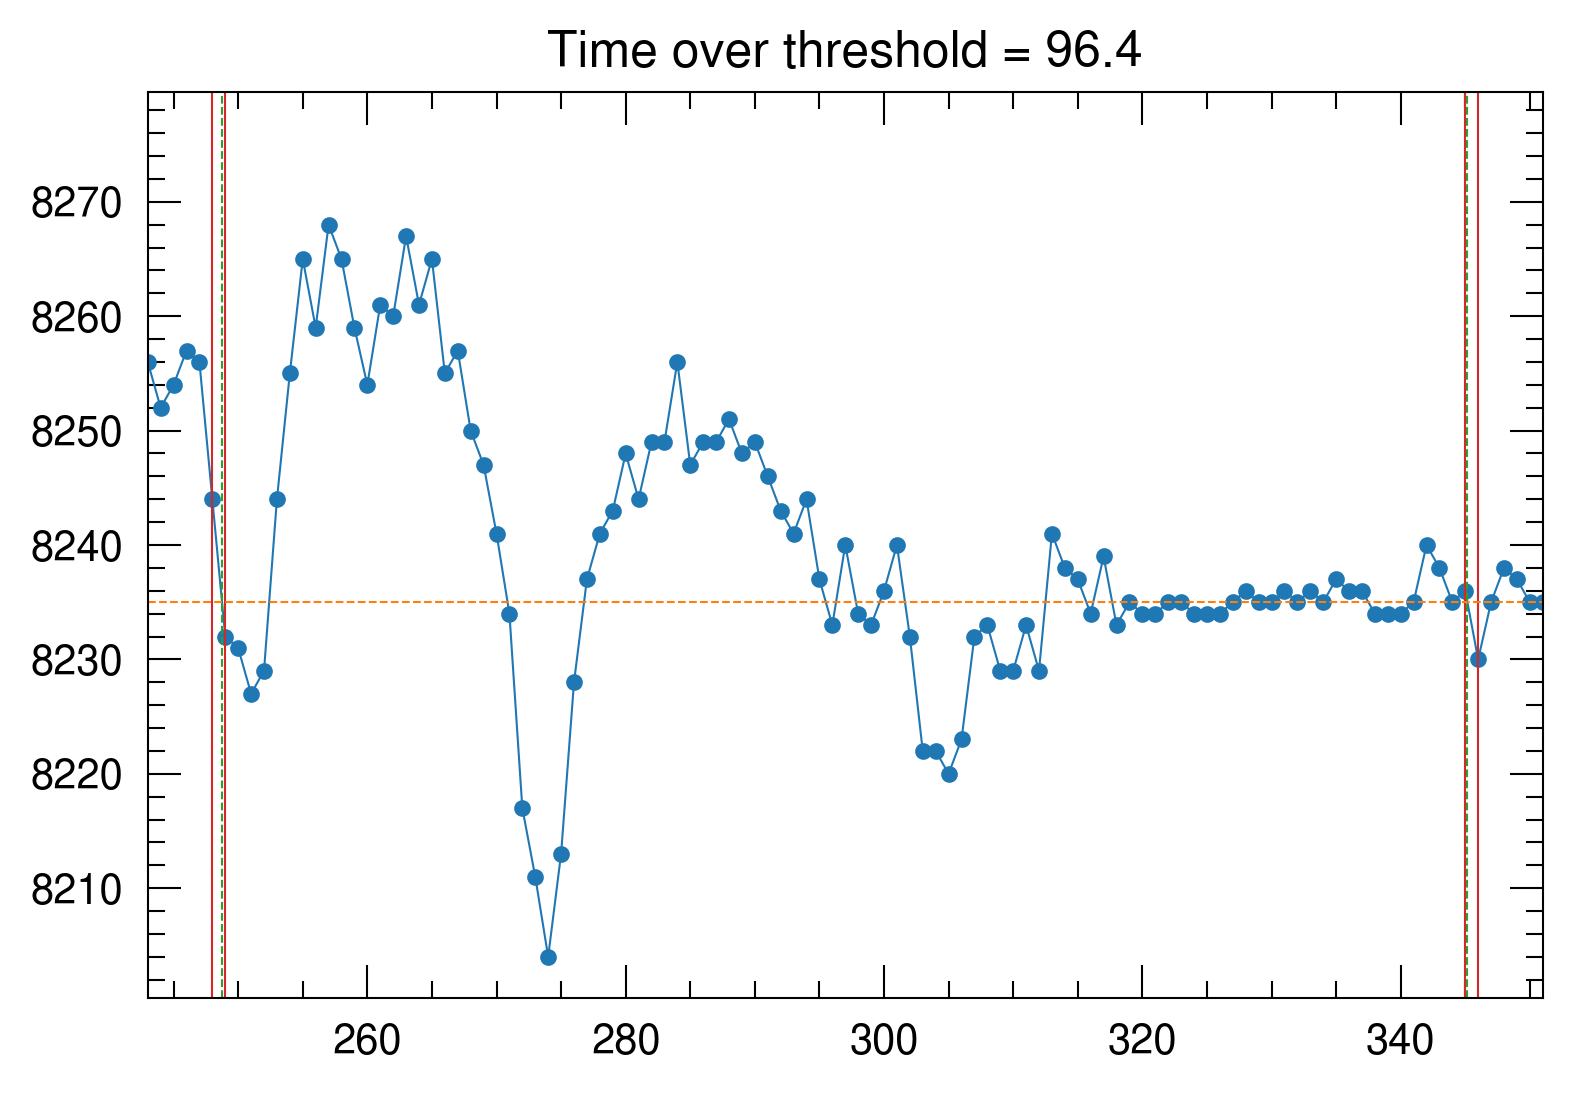

In [287]:
# I'm taking the threshold as before as an example
waveform = waveforms[8, :]
samples_below_threshold = waveform < threshold
# Find the indices xfb and xlb
xfb = np.argmax(samples_below_threshold) - 1
xlb = window_length - np.argmax(samples_below_threshold[::-1]) - 2
# The corresponding yfb and ylb are easy to get:
yfb, ylb = waveform[xfb], waveform[xlb]
# Now we can also find the coordinates of the samples
# after meeting the threshold
xfa, yfa = xfb + 1, waveform[xfb + 1]
xla, yla = xlb + 1, waveform[xlb + 1]
# Find xf and xl
xf = xfb + (xfa - xfb) * ((threshold - yfb) / (yfa - yfb))
xl = xlb + (xla - xlb) * ((threshold - ylb) / (yla - ylb))
time_over_threshold = xl - xf

# Let's visualize everything
fig, ax = plt.subplots()
ax.plot(waveform, '.-')
ax.axvline(xfb, color='C3')
ax.axvline(xf, color='C2', linestyle='--')
ax.axvline(xfa, color='C3')

ax.axvline(xlb, color='C3')
ax.axvline(xl, color='C2', linestyle='--')
ax.axvline(xla, color='C3')

ax.axhline(threshold, color='C1', linestyle='--')

# zoom in in the region of interest
ax.set(xlim=(xfb - 5, xla + 5), title=f'Time over threshold = {time_over_threshold:.1f}')

As expected, the time over threshold is now computed as the intersection between the horizontal lines and the segments first and last crossing the threshold.
The code above is failing in case the threshold is not crossing any segment:

In [89]:
# Waveform 9 is not crossing the threshold
waveform = waveforms[9, :]
samples_below_threshold = waveform < threshold
# np.argmax returns 0 if nothing is found
xfb = np.argmax(samples_below_threshold) - 1
# This would generated some issues because it's 520 - 0 = 520 
xlb = window_length - np.argmax(samples_below_threshold[::-1]) 
# This part will throw an error because waveform has only
# 520 samples and waveform[520] is outside range
yfb, ylb = waveform[xfb], waveform[xlb]
# ...

IndexError: index 520 is out of bounds for axis 0 with size 520

The code is failing because it's not possible to find the x coordinates for the segment last crossing the threshold. This results in a value of $x_{lb}$ of 520 that is outside the range of the array (which starts from 0 to 519). A possible solution could be to set the values of $x_{lb}$ to be 0 or `np.nan` in case they are found to be 520. This would result in a time over threshold of 0. This is the cleaniest solution I could find:

In [91]:
waveform = waveforms[9, :]
samples_below_threshold = waveform < threshold
xfb = np.argmax(samples_below_threshold) - 1
# Set xfb to be nan in case no threshold crossing
# is found. The same for xlb
xfb = np.where(xfb != -1, xfb, 0)
xlb = window_length - np.argmax(samples_below_threshold[::-1]) 
xlb = np.where(xlb != window_length, xlb, 0)
# The corresponding yfb and ylb are easy to get:
yfb, ylb = waveform[xfb], waveform[xlb]
# ... time over threshold will result in a 0 value



## The 2d case

The 2d case is a bit more complicated as it involves the usual `numpy` model to solve this problem in an efficient way. Nevertheless, the steps to approach the problem are the same so the code looks like the following:

/tmp/ipykernel_389329/2995661854.py:20: RuntimeWarning: divide by zero encountered in true_divide
  xl = xlb + (xla - xlb) * ((threshold - ylb) / (yla - ylb))


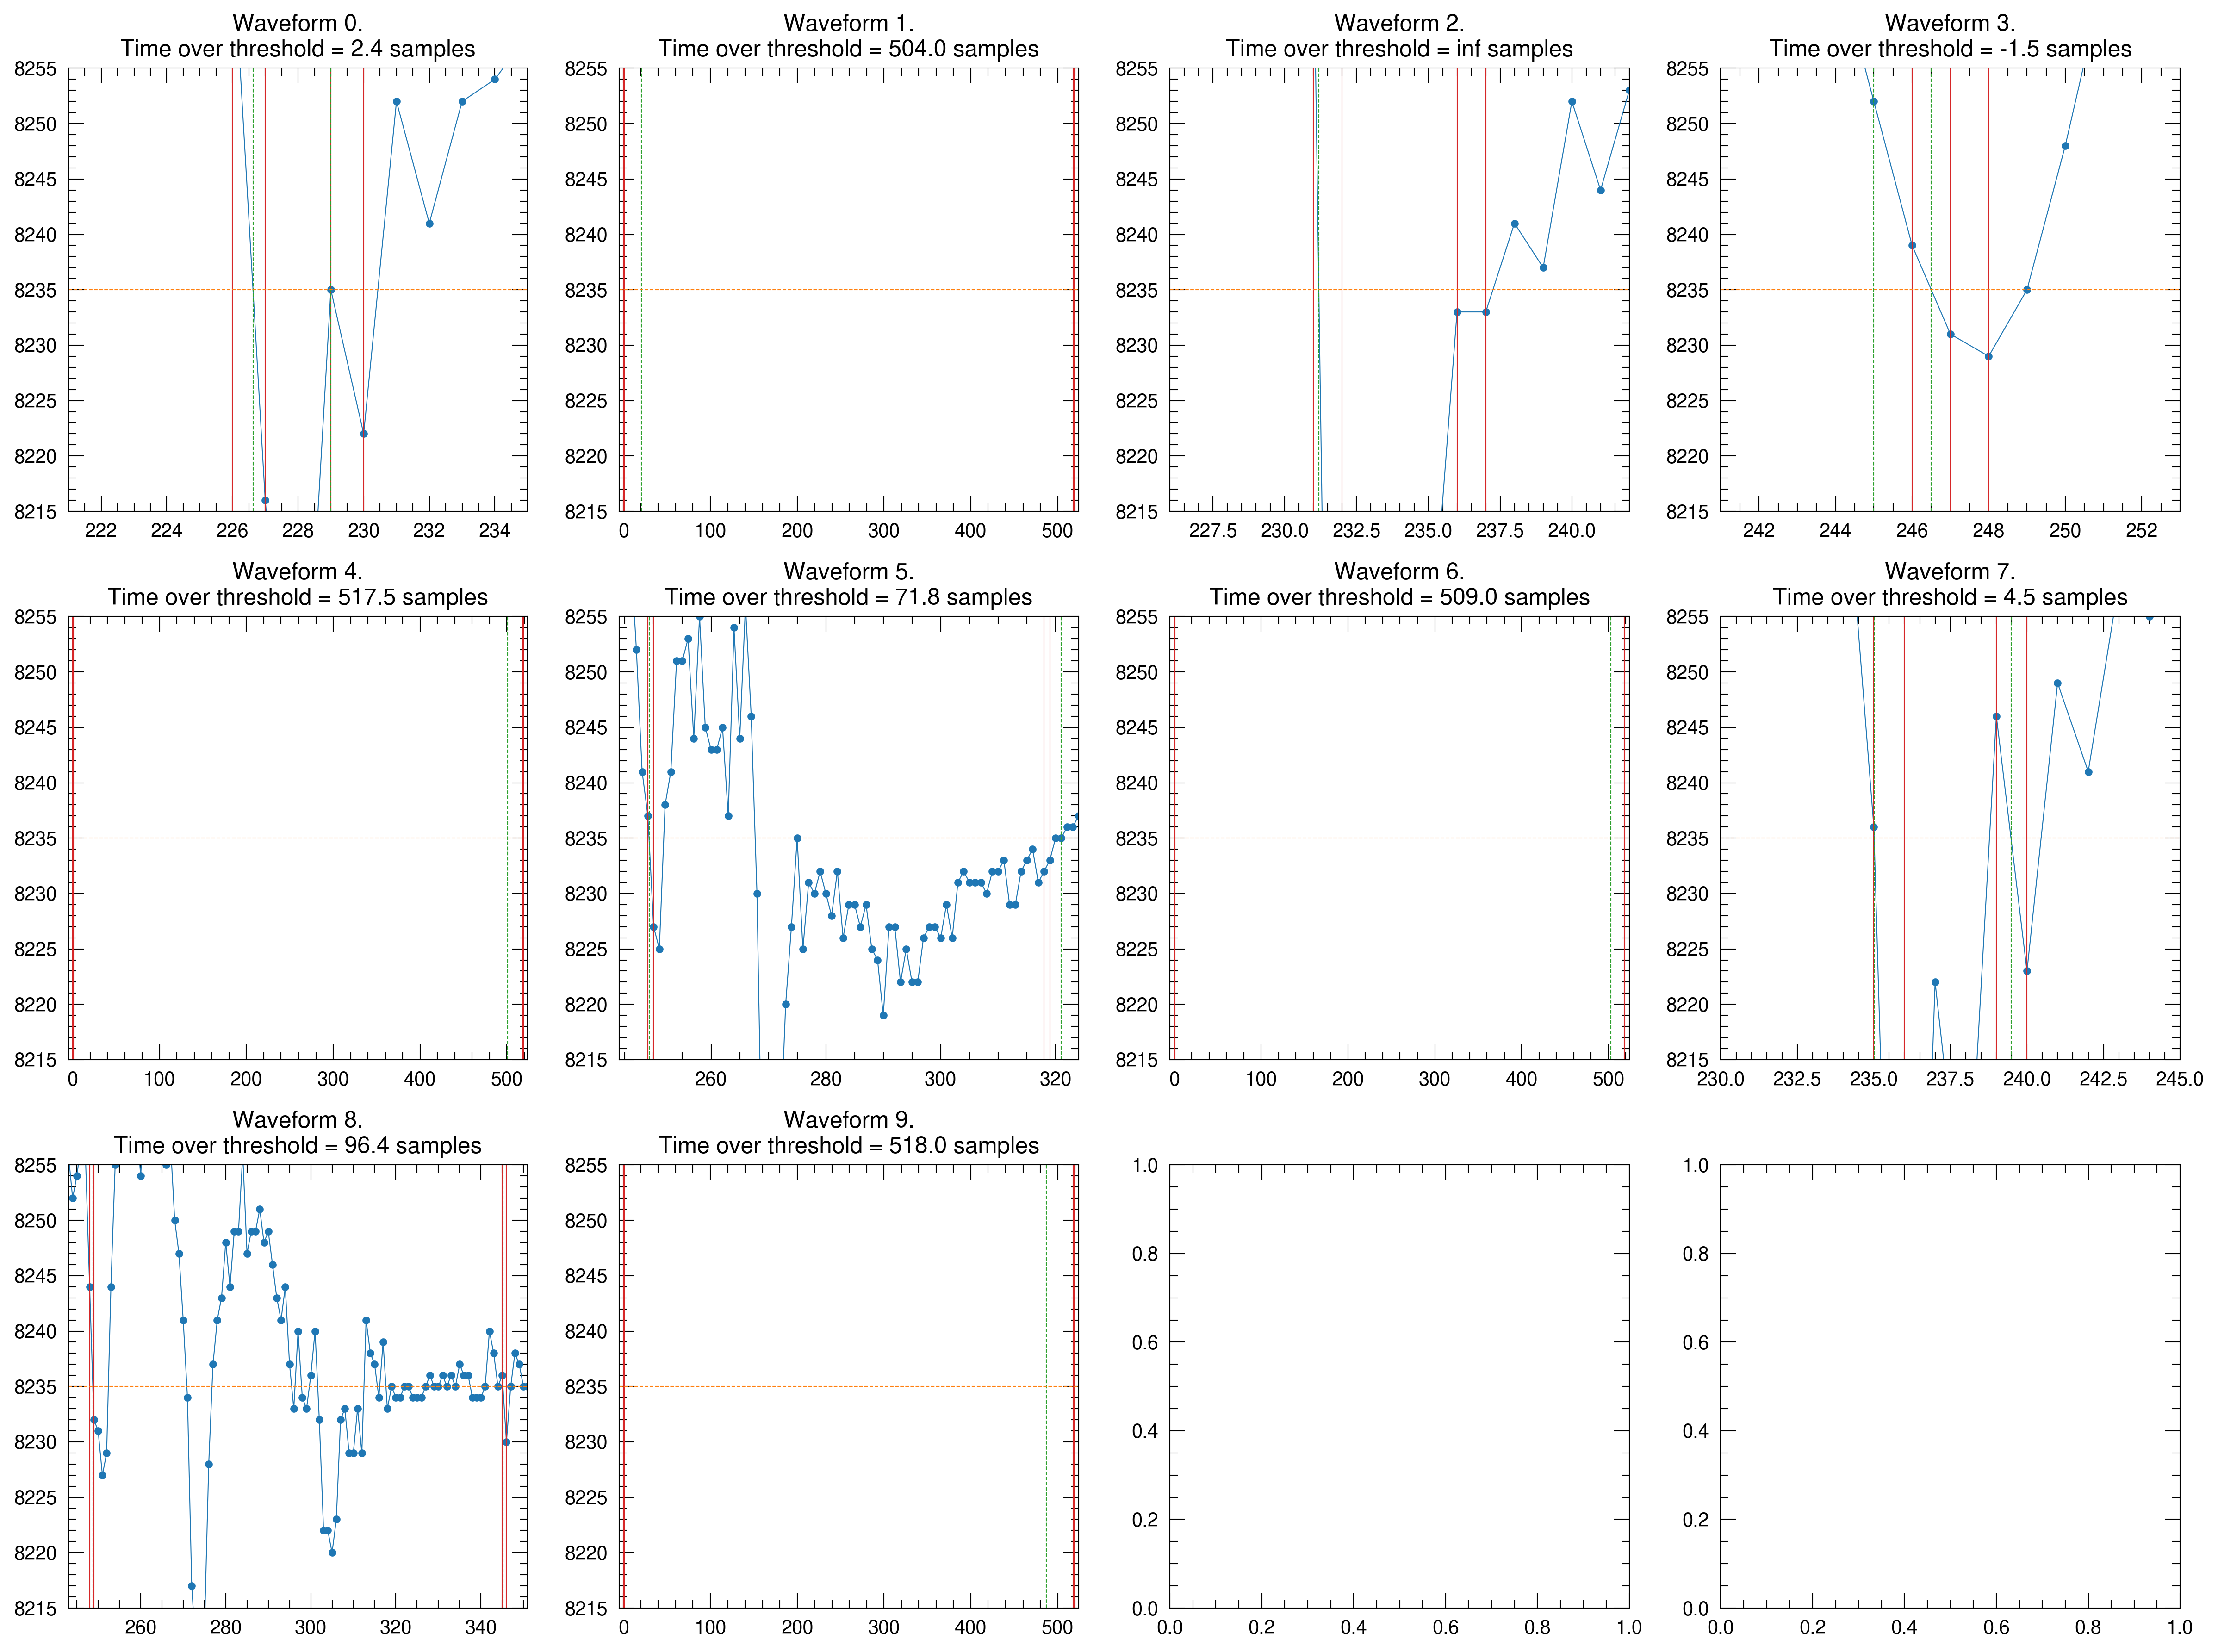

In [286]:
samples_below_threshold = waveforms < threshold
# Find the indices xfb and xlb
xfb = np.argmax(samples_below_threshold, axis=1) - 1
# Add np.where condition to handle signal without threshold crossing
xfb = np.where(xfb != -1, xfb, 0)
xlb = window_length - np.argmax(samples_below_threshold[:, ::-1], axis=1) - 2
xlb = np.where(xlb != window_length, xlb, 0)
# Taking indices along a 2d array is a bit
# more complicated. There are few different
# ways to do it
yfb = np.take_along_axis(waveforms, xfb[:, None], axis=1).flatten()
ylb = np.take_along_axis(waveforms, xlb[:, None], axis=1).flatten()

xfa = xfb + 1
yfa = np.take_along_axis(waveforms, xfb[:, None] + 1, axis=1).flatten()
xla = xlb + 1
yla = np.take_along_axis(waveforms, xlb[:, None] + 1, axis=1).flatten()

xf = xfb + (xfa - xfb) * ((threshold - yfb) / (yfa - yfb))
xl = xlb + (xla - xlb) * ((threshold - ylb) / (yla - ylb))
time_over_threshold = xl - xf

# Let's visualize everything
fig, axs = plt.subplots(3, 4, figsize=(4*4, 4*3))
for ix, waveform in enumerate(waveforms):
    ax = axs.flat[ix]
    ax.plot(waveform, '.-')
    ax.axvline(xfb[ix], color='C3')
    ax.axvline(xf[ix], color='C2', linestyle='--')
    ax.axvline(xfa[ix], color='C3')

    ax.axvline(xlb[ix], color='C3')
    ax.axvline(xl[ix], color='C2', linestyle='--')
    ax.axvline(xla[ix], color='C3')

    ax.axhline(threshold, color='C1', linestyle='--')

    ax.set(xlim=(xfb[ix] - 5, xla[ix] + 5), 
    ylim=(threshold - 20, threshold + 20),
    title=f'Waveform {ix}.\nTime over threshold = {time_over_threshold[ix]:.1f} samples')
    fig.tight_layout()

You may notice that there are few corner cases that may arise. For instance, have a look at waveform 5: the resulting time over threshold is `nan`. In this case, if the segment defined by $(x_{lb}, y_{lb}), (x_{la}, y_{la})$ and crossing the threshold is parallel to the threshold itself,
the values of either $y_{fa} - y_{fb}$ or $y_{la} - y_{lb}$ are equal to 0, resulting in an error similar to: 
```
RuntimeWarning: invalid value encountered in true_divide
  xl = xlb + (xla - xlb) * ((threshold - ylb) / (yla - ylb))
``` 

A possible solution to this is to handle the division using `np.divide`, which allows to use a `where` option and that allows to avoid to `try/catch` or use a context manager to handle the error. For more information see this [Stack overflow post](https://stackoverflow.com/questions/26248654/how-to-return-0-with-divide-by-zero).

The code above will become the following:

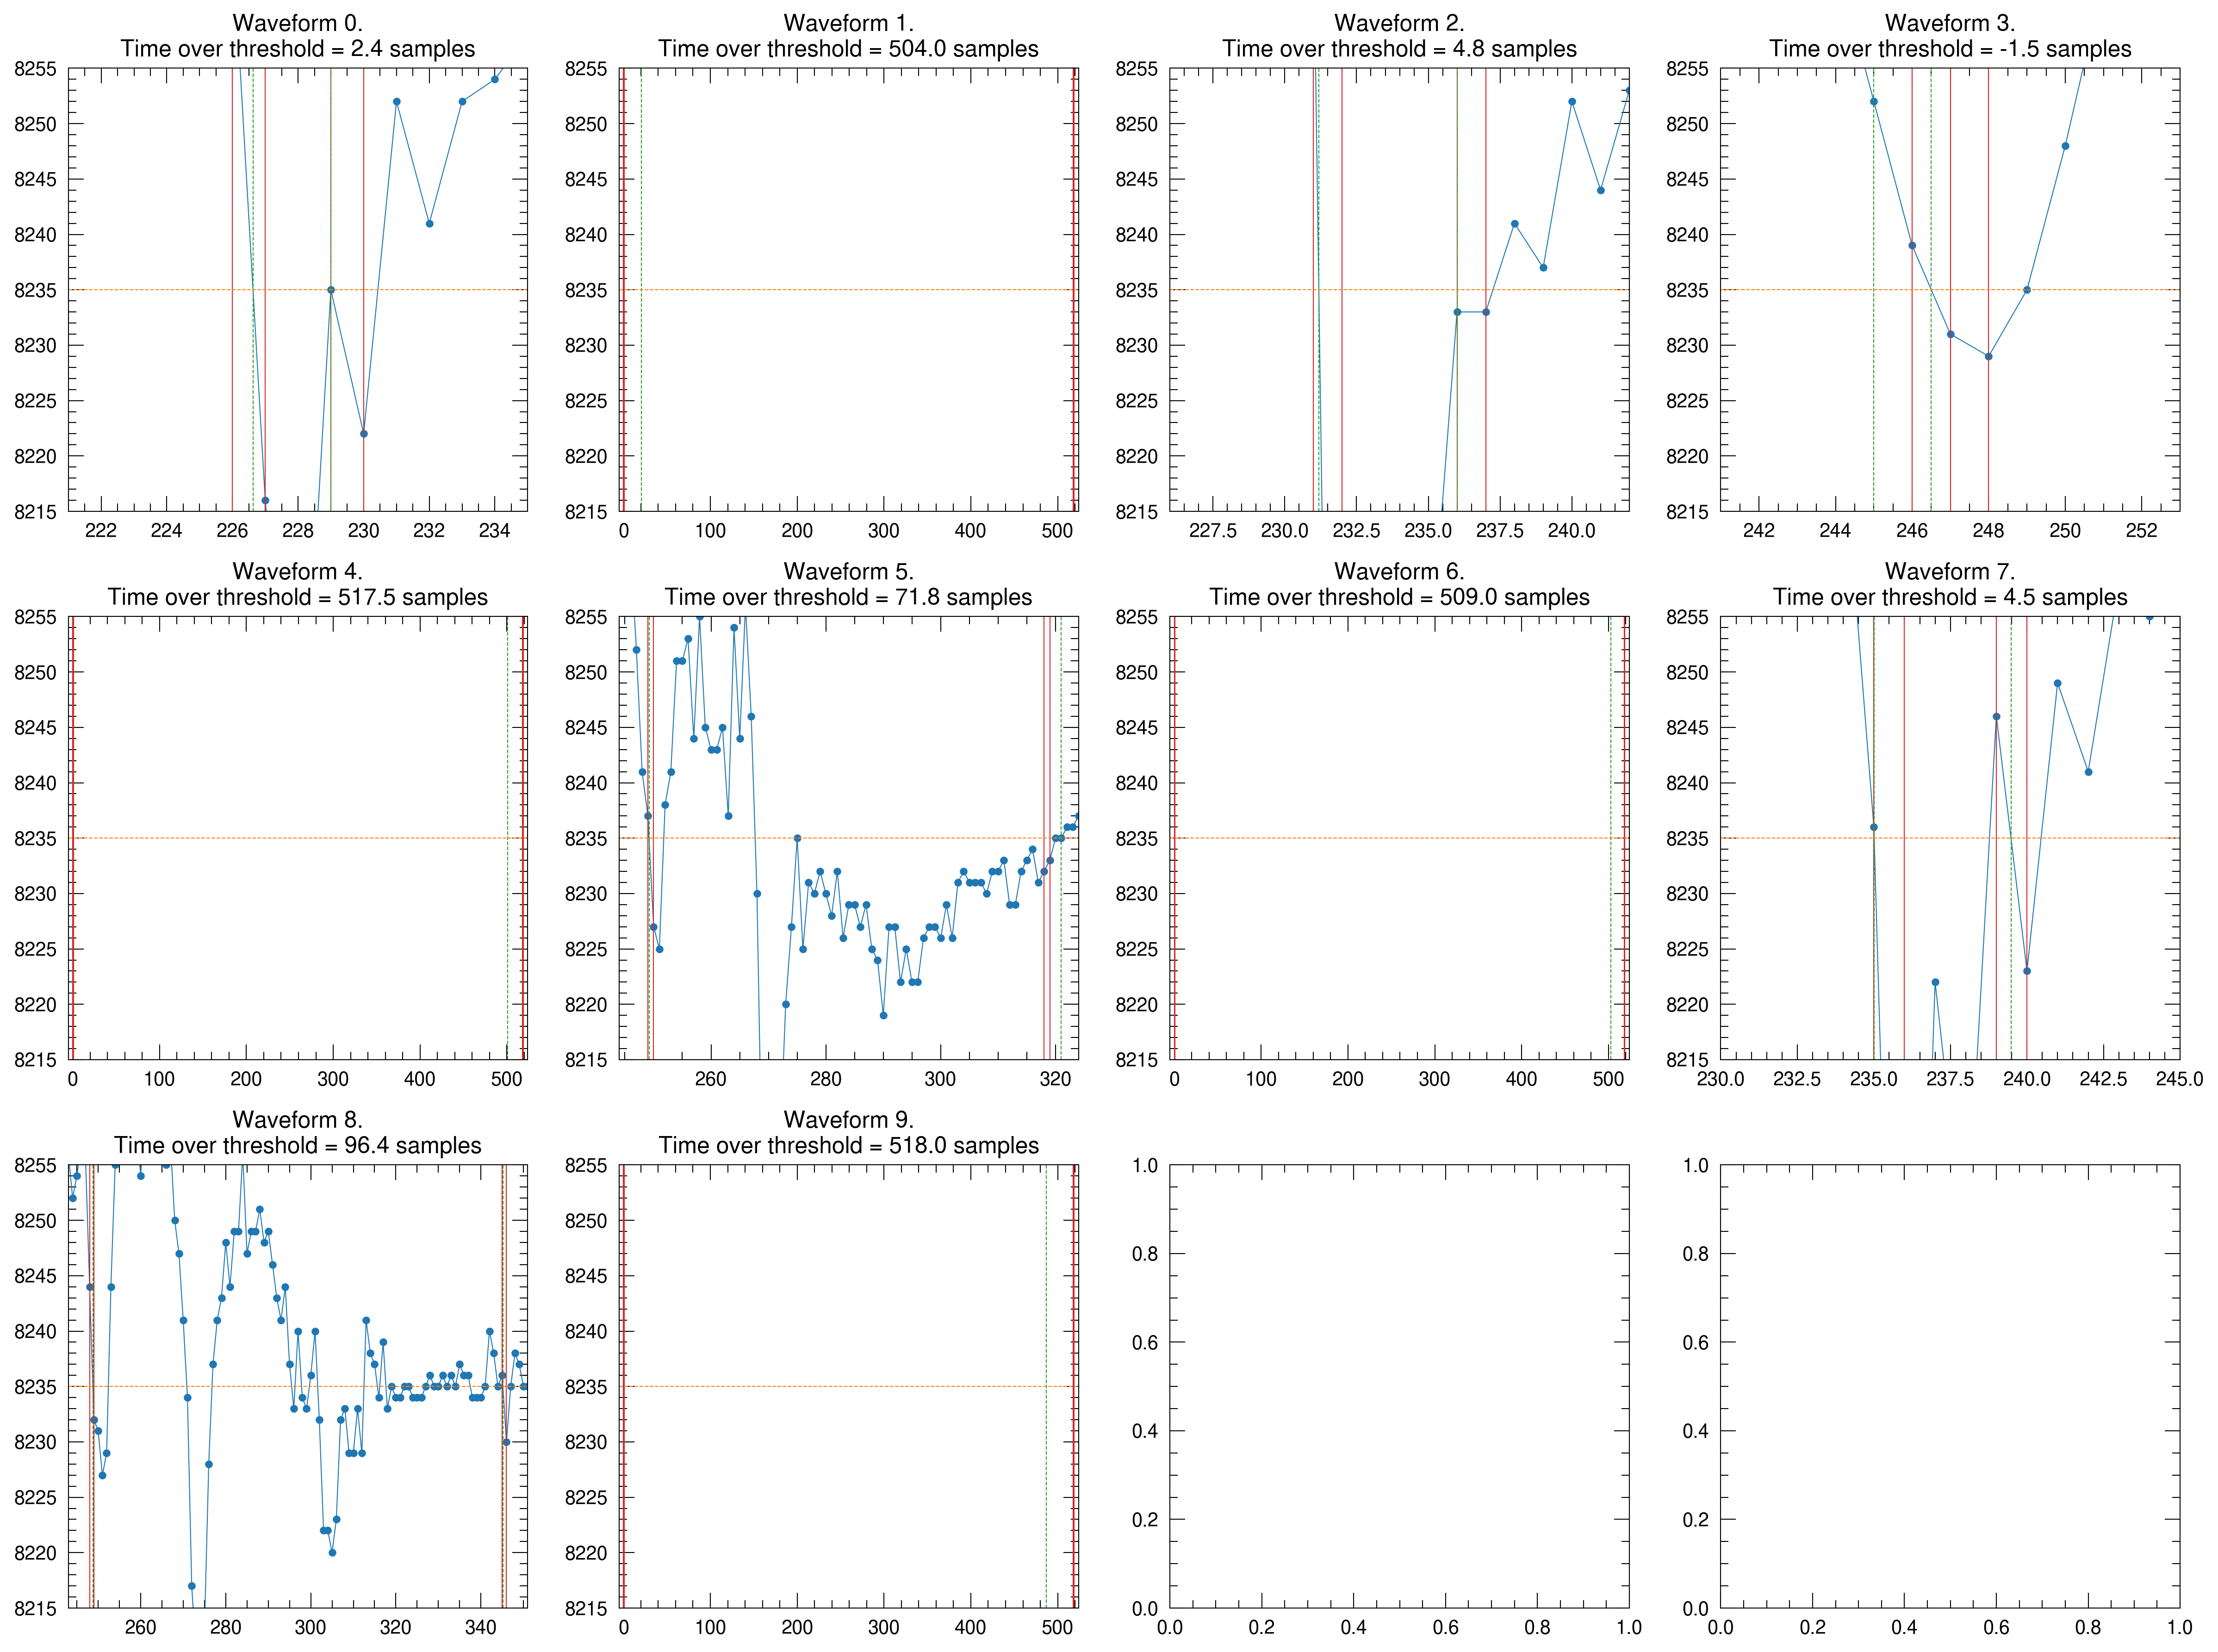

In [285]:
samples_below_threshold = waveforms < threshold
# Find the indices xfb and xlb
xfb = np.argmax(samples_below_threshold, axis=1) - 1
# Add np.where condition to handle signal without threshold crossing
xfb = np.where(xfb != -1, xfb, 0)
xlb = window_length - np.argmax(samples_below_threshold[:, ::-1], axis=1) - 2
xlb = np.where(xlb != window_length, xlb, 0)
# Taking indices along a 2d array is a bit
# more complicated. There are few different
# ways to do it
yfb = np.take_along_axis(waveforms, xfb[:, None], axis=1).flatten()
ylb = np.take_along_axis(waveforms, xlb[:, None], axis=1).flatten()

xfa = xfb + 1
yfa = np.take_along_axis(waveforms, xfb[:, None] + 1, axis=1).flatten()
xla = xlb + 1
yla = np.take_along_axis(waveforms, xlb[:, None] + 1, axis=1).flatten()

# temp_yf and temp_yl are the arrays to use in case the 'where' condition is False. 
# If the 'where' condition is true, then the np.divide() result is used instead
temp_yf, temp_yl = np.zeros_like(yfa, dtype='float64'), np.zeros_like(ylb, dtype='float64')
xf = xfb + (xfa - xfb) * (np.divide((threshold - yfb) , (yfa - yfb), out=temp_yf, where=(yfa - yfb) != 0))
xl = xlb + (xla - xlb) * (np.divide((threshold - ylb) , (yla - ylb), out=temp_yl, where=(yla - ylb) != 0))
time_over_threshold = xl - xf

# Let's visualize everything
fig, axs = plt.subplots(3, 4, figsize=(4*4, 4*3))
for ix, waveform in enumerate(waveforms):
    ax = axs.flat[ix]
    ax.plot(waveform, '.-')
    ax.axvline(xfb[ix], color='C3')
    ax.axvline(xf[ix], color='C2', linestyle='--')
    ax.axvline(xfa[ix], color='C3')

    ax.axvline(xlb[ix], color='C3')
    ax.axvline(xl[ix], color='C2', linestyle='--')
    ax.axvline(xla[ix], color='C3')

    ax.axhline(threshold, color='C1', linestyle='--')

    ax.set(xlim=(xfb[ix] - 5, xla[ix] + 5), 
    ylim=(threshold - 20, threshold + 20),
    title=f'Waveform {ix}.\nTime over threshold = {time_over_threshold[ix]:.1f} samples')
    fig.tight_layout()

## Handling corner cases

Unfortunately, the code below does not handle all the cases. Let's wrap the previous code into a function and prepare some test cases

In [508]:
def compute_time_over_threshold(data: np.ndarray, threshold: float | int | np.ndarray) -> np.ndarray: 
    """Compute the time over threshold for a 1d or 2d array given a fixed threshold. The
    time over threshold is defined as the difference between the intersection of the
    threshold with the segments of the samples: the last - the first segments
    crossing this threshold define the tot. In case no samples cross the
    tot, the resulting value is 0.as_integer_ratio
    
    Parameters
    ----------
    data: ndarray
        1d or 2d array of shape (n_waveforms, n_samples)
    threshold: float or int or ndarray (n_waveforms)
        a fixed threshold for all the waveforms or a set of threshold
        for each waveform

    Returns
    -------
    out: ndarray
        a 1d array of the time over thresholds of shape (n_waveforms)
    """
    # In case of a 1d array of shape (n_samples), convert it to a 2d
    # array of shape (1, n_samples), so that the code can be used for
    # both 1d and 2d array
    if data.ndim == 1:
        waveforms = data[None, :]
    else:
        waveforms = data
    # The same operation for threshold:
    if not isinstance(threshold, np.ndarray):
        threshold = np.array([threshold])

    window_length = waveforms.shape[1]
    
    samples_below_threshold = waveforms < threshold[:, None]
    # Find the indices xfb and xlb
    xfb = np.argmax(samples_below_threshold, axis=1) - 1
    # Add np.where condition to handle signal without threshold crossing
    xfb = np.where(xfb != -1, xfb, 0)
    xlb = window_length - np.argmax(samples_below_threshold[:, ::-1], axis=1) - 1
    xlb = np.where(xlb != window_length - 1, xlb, 0)
    # Taking indices along a 2d array is a bit
    # more complicated. There are few different
    # ways to do it
    yfb = np.take_along_axis(waveforms, xfb[:, None], axis=1).flatten()
    ylb = np.take_along_axis(waveforms, xlb[:, None], axis=1).flatten()

    xfa = xfb + 1
    yfa = np.take_along_axis(waveforms, xfb[:, None] + 1, axis=1).flatten()
    xla = xlb + 1
    yla = np.take_along_axis(waveforms, xlb[:, None] + 1, axis=1).flatten()

    # temp_yf and temp_yl are the arrays to use in case the 'where' condition is False. 
    # If the 'where' condition is true, then the np.divide() result is used instead
    temp_yf, temp_yl = np.zeros_like(yfa, dtype='float64'), np.zeros_like(ylb, dtype='float64')
    xf = xfb + (xfa - xfb) * (np.divide((threshold - yfb) , (yfa - yfb), out=temp_yf, where=(yfa - yfb) != 0))
    xl = xlb + (xla - xlb) * (np.divide((threshold - ylb) , (yla - ylb), out=temp_yl, where=(yla - ylb) != 0))
    time_over_threshold = xl - xf

    return time_over_threshold

waveform_test = np.array([-1, -1, -1, -1, -1])
threshold_test = -0.5
tot = compute_time_over_threshold(waveform_test, threshold_test)
expected_tot = np.array([4])
tot, expected_tot

(array([0.]), array([4]))

Here I wrapped everything into a function and added few initial lines of codes to transform a 1d array into a 2d array with the first dimension set to 1. This allows me to reuse the same code for the case in which we have a single waveform or multiple ones. The same applies for the threshold: if it is a scalar then it's converted to a 1d array.

Let's test the function with a simple case: there are no points going below the threshold:

In [504]:
waveform_test = np.array([0, 0, 0, 0, 0])
threshold_test = -1
tot = compute_time_over_threshold(waveform_test, threshold_test)
expected_tot = np.array([0])
tot, expected_tot

(array([0.]), array([0]))

So far so good. Now I want to test a simple case in which the time over threshold should be a simple scalar value.

In [505]:
waveform_test = np.array([0, -1, -1, -1, 0])
threshold_test = -0.5
tot = compute_time_over_threshold(waveform_test, threshold_test)
expected_tot = np.array([3])
tot, expected_tot

(array([3.]), array([3]))

The time over threshold is working fine in this case. Few other corners cases: all samples are below threshold, so the computed time over threshold should be equal to the window length

In [507]:
waveform_test = np.array([-1, -1, -1, -1, -1])
threshold_test = -0.5
tot = compute_time_over_threshold(waveform_test, threshold_test)
expected_tot = np.array([4])
tot, expected_tot

(array([0.]), array([4]))

In this case the time over threshold is not computed properly. The issue arises due to the way `xlb` is handled. In particular,
in line `40`, the part `xlb = np.where(xlb != window_length - 1, xlb, 0)` is setting the values of `xlb` to 0 in case `xlb == window_length - 1`. The problem is that there are two cases in which `xlb` could be equal to `window_length - 1`. One case is when the last sample is actually the last crossing the threshold. The second is the one where no samples are crossing the threshold, so `np.argmax()` returns the first item of the array, which in the reversed case is `window_length - 1`.

For this reason, it is important to distinguish the two cases and handle them separately. In the case of two conditions `xlb == window_length - 1` and `np.all(samples_below_threshold == True, axis=1)` happening at the same time then all the samples are already below the threshold, thus the time over threshold will be equal to the `window_length`. Instead, in the case of `xlb == window_length - 1` and `np.any(samples_below_threshold == True, axis=1)` it means there
is at least one sample below the threshold so we can calculate the time over threshold as expected. It could be all the samples but in that case we would fall into the previous condition, so it should be already handled.

Additionally, `xla` should be also modified:  if `xlb == window_length - 1` then it means the last sample is still below the threshold, so `xla` can be set to be equal to `xlb` in order to compute the time over threshold on the last point (which is a segment delimited by $x_{la}, x_{lb}$, so a segment with length 0). Otherwsise, `xlb` can be set to `xla + 1` as usual.

Below the updated code:


In [509]:
def compute_time_over_threshold(data: np.ndarray, threshold: float | int | np.ndarray) -> np.ndarray: 
    """Compute the time over threshold for a 1d or 2d array given a fixed threshold. The
    time over threshold is defined as the difference between the intersection of the
    threshold with the segments of the samples: the last - the first segments
    crossing this threshold define the tot. In case no samples cross the
    tot, the resulting value is 0.as_integer_ratio
    
    Parameters
    ----------
    data: ndarray
        1d or 2d array of shape (n_waveforms, n_samples)
    threshold: float or int or ndarray (n_waveforms)
        a fixed threshold for all the waveforms or a set of threshold
        for each waveform

    Returns
    -------
    out: ndarray
        a 1d array of the time over thresholds of shape (n_waveforms)
    """
    # In case of a 1d array of shape (n_samples), convert it to a 2d
    # array of shape (1, n_samples), so that the code can be used for
    # both 1d and 2d array
    if data.ndim == 1:
        waveforms = data[None, :]
    else:
        waveforms = data
    # The same operation for threshold:
    if not isinstance(threshold, np.ndarray):
        threshold = np.array([threshold])
    
    samples_below_threshold = waveforms < threshold[:, None]
    window_length = waveforms.shape[1]

    xfb = np.argmax(samples_below_threshold, axis=1) - 1
    xfb = np.where(xfb != -1, xfb, 0)
    xlb = window_length - np.argmax(samples_below_threshold[:, ::-1], axis=1) - 1
    # Notice I removed the np.where() condition on xlb

    yfb = np.take_along_axis(waveforms, xfb[:, None], axis=1).flatten()
    ylb = np.take_along_axis(waveforms, xlb[:, None], axis=1).flatten()

    xfa = xfb + 1
    yfa = np.take_along_axis(waveforms, xfa[:, None], axis=1).flatten()
    # Here I put a condition on xla: if xlb is the last item, then xla
    # should be the same as xlb, so the segment (xlb-xla) is of length 0
    xla = np.where(xlb == window_length - 1, xlb, xlb + 1)
    yla = np.take_along_axis(waveforms, xla[:, None], axis=1).flatten()

    xf = xfb + (np.divide((threshold - yfb) , (yfa - yfb), out=np.zeros_like(yfa, dtype='float64'), where=((yfa - yfb) != 0)))
    xl = xlb + (np.divide((threshold - ylb) , (yla - ylb), out=np.zeros_like(yfa, dtype='float64'), where=((yla - ylb) != 0)))
    # Use np.select() as a case statement:
    time_over_threshold = np.select(condlist=[
        (xlb != window_length - 1) & (np.all(samples_below_threshold == True, axis=1)),  # all points crossing threshold
        (xlb != window_length - 1) & (np.any(samples_below_threshold == True, axis=1)),  # at least one point crossing threshold
        (xlb == window_length - 1) & (np.all(samples_below_threshold == False, axis=1)), # no real points crossing threshold
        (xlb == window_length - 1) & (np.any(samples_below_threshold == True, axis=1)), # last point crossing threshold
    ], choicelist=[
        window_length,
        xl-xf,
        0, 
        xl-xf
    ])
    
    return time_over_threshold

As you can see I removed the `np.where()` condition onf `xlb` and added one on `xla`. If I didn't, then when `xlb` is equal to `window_length - 1`, `xla` would be equal to `window_length`, resulting in an error when trying to access the array since the last item is at `window_length - 1`. 

Also, I added `np.select()` which I usually think of as a n-dimensional version of a case statement. In case `xlb != window_length - 1` there could be either all points crossing the threshold or at least one, so the time over threshold would be either the whole `window_length` or the computed `xl - xf` value. 

In case `xlb == window_length - 1` then there could be either no points at all crossing the threshold (`time_over_threshold = 0`) or there could be only the lat one crossing it, so the time over threshold would be again computed in the standard way of `xl - xf`.



Now the case in which the first sample is already below the threshold but not the last is correctly handled:

In [511]:
waveform_test = np.array([-1, -1, -1, 0, 0])
threshold_test = -0.5
tot = compute_time_over_threshold(waveform_test, threshold_test)
expected_tot = np.array([2.5])
tot, expected_tot

(array([2.5]), array([2.5]))

Here below you can find the final the final code I use for the time over threshold calculation and few test cases:

In [404]:
#| code-fold: true
def compute_time_over_threshold(data: np.ndarray, threshold: float | int | np.ndarray) -> np.ndarray: 
    """Compute the time over threshold for a 1d or 2d array given a fixed threshold. The
    time over threshold is defined as the difference between the intersection of the
    threshold with the segments of the samples: the last - the first segments
    crossing this threshold define the tot. In case no samples cross the
    tot, the resulting value is 0.as_integer_ratio
    
    Parameters
    ----------
    data: ndarray
        1d or 2d array of shape (n_waveforms, n_samples)
    threshold: float or int or ndarray (n_waveforms)
        a fixed threshold for all the waveforms or a set of threshold
        for each waveform

    Returns
    -------
    out: ndarray
        a 1d array of the time over thresholds of shape (n_waveforms)
    """
    # In case of a 1d array of shape (n_samples), convert it to a 2d
    # array of shape (1, n_samples), so that the code can be used for
    # both 1d and 2d array
    if data.ndim == 1:
        waveforms = data[None, :]
    else:
        waveforms = data
    # The same operation for threshold:
    if not isinstance(threshold, np.ndarray):
        threshold = np.array([threshold])
    
    samples_below_threshold = waveforms < threshold[:, None]
    window_length = waveforms.shape[1]

    xfb = np.argmax(samples_below_threshold, axis=1) - 1
    xfb = np.where(xfb != -1, xfb, 0)
    xlb = window_length - np.argmax(samples_below_threshold[:, ::-1], axis=1) - 1

    yfb = np.take_along_axis(waveforms, xfb[:, None], axis=1).flatten()
    ylb = np.take_along_axis(waveforms, xlb[:, None], axis=1).flatten()

    xfa = xfb + 1
    yfa = np.take_along_axis(waveforms, xfa[:, None], axis=1).flatten()
    xla = np.where(xlb == window_length - 1, xlb, xlb + 1)
    yla = np.take_along_axis(waveforms, xla[:, None], axis=1).flatten()

    xf = xfb + (np.divide((threshold - yfb) , (yfa - yfb), out=np.zeros_like(yfa, dtype='float64'), where=((yfa - yfb) != 0)))
    xl = xlb + (np.divide((threshold - ylb) , (yla - ylb), out=np.zeros_like(yfa, dtype='float64'), where=((yla - ylb) != 0)))
    time_over_threshold = np.select(condlist=[
        (xlb != window_length - 1) & (np.all(samples_below_threshold == True, axis=1)),  # all points crossing threshold
        (xlb != window_length - 1) & (np.any(samples_below_threshold == True, axis=1)),  # at least one point crossing threshold
        (xlb == window_length - 1) & (np.all(samples_below_threshold == False, axis=1)), # no real point crossing threshold
        (xlb == window_length - 1) & (np.any(samples_below_threshold == True, axis=1)), # last point
    ], choicelist=[
        window_length,
        xl-xf,
        0,
        xl-xf
    ])
    
    return time_over_threshold

Few test cases here below:

In [405]:
#| code-fold: true
waveform_test = np.array([0, 0, -1, -4, -4, -3, -1, 0, 0])
threshold_test = 1
compute_time_over_threshold(waveform_test, threshold_test)

array([8.])

In [406]:
#| code-fold: true
waveform_test = np.array([0, 0, -1, -4, -4, -3, -1, 0, 0])
threshold_test = -10
compute_time_over_threshold(waveform_test, threshold_test)

array([0.])

In [407]:
#| code-fold: true
waveform_test = np.array([-2, -1.5, -1, -4, -4, -3, -2, 0, 0])
threshold_test = -1
compute_time_over_threshold(waveform_test, threshold_test)

array([4.5])

In [408]:
#| code-fold: true
waveform_test = np.array([0, 0, -1, -4, -4, -3, -1, 0, -4])
threshold_test = -2
compute_time_over_threshold(waveform_test, threshold_test)

array([5.66666667])

In [409]:
#| code-fold: true
waveform_test = np.array([0, 0, -1, -4, -4, -3, -1, 0, 0])
threshold_test = -2
compute_time_over_threshold(waveform_test, threshold_test)

array([3.16666667])

In [413]:
#| code-fold: true
waveform_test = np.array([0, 0, -1, -4, -4, -3, -2, 0, 0])
threshold_test = -2.2
compute_time_over_threshold(waveform_test, threshold_test)

array([3.4])

In [414]:
#| code-fold: true
waveform_test = np.array([
    [0, 0, -1, -4, -4, -3, -1.5, 0, 0],
    [0, 0, -1, 2, 1, -2, 1.5, 0, 0],
])
threshold_test = -2.2
compute_time_over_threshold(waveform_test, threshold_test)

array([3.13333333, 0.        ])

In [343]:
#| code-fold: true
waveform_test = np.array([
    [0, 0, -1, -4, -4, -3, -1.5, 0, 0],
    [0, 0, -1, 2, 1, -2, 1.5, 0, 0],
])
threshold_test = np.array([-2.2, -1])
compute_time_over_threshold(waveform_test, threshold_test)

array([3.13333333, 0.61904762])

# Why I needed linear interpolation

The readout system I use to sample signal is poorly resoluted compared to the average time over threshold of the signals, so I wanted to have a linear interpolation to allow me to compute proper distributions of the time over threshold. This is possible thanks to the intrinsic time jitter of the 
digitizer which is of few order of magnitude lower than its sampling frequency. 

For example, a digitizer can have a sampling frequency of 500 Ms/s but a time jitter (or time resolution) of 50 ps.

The two plots here below shows the difference between using the simple version of the time over threshold and the implemented one.

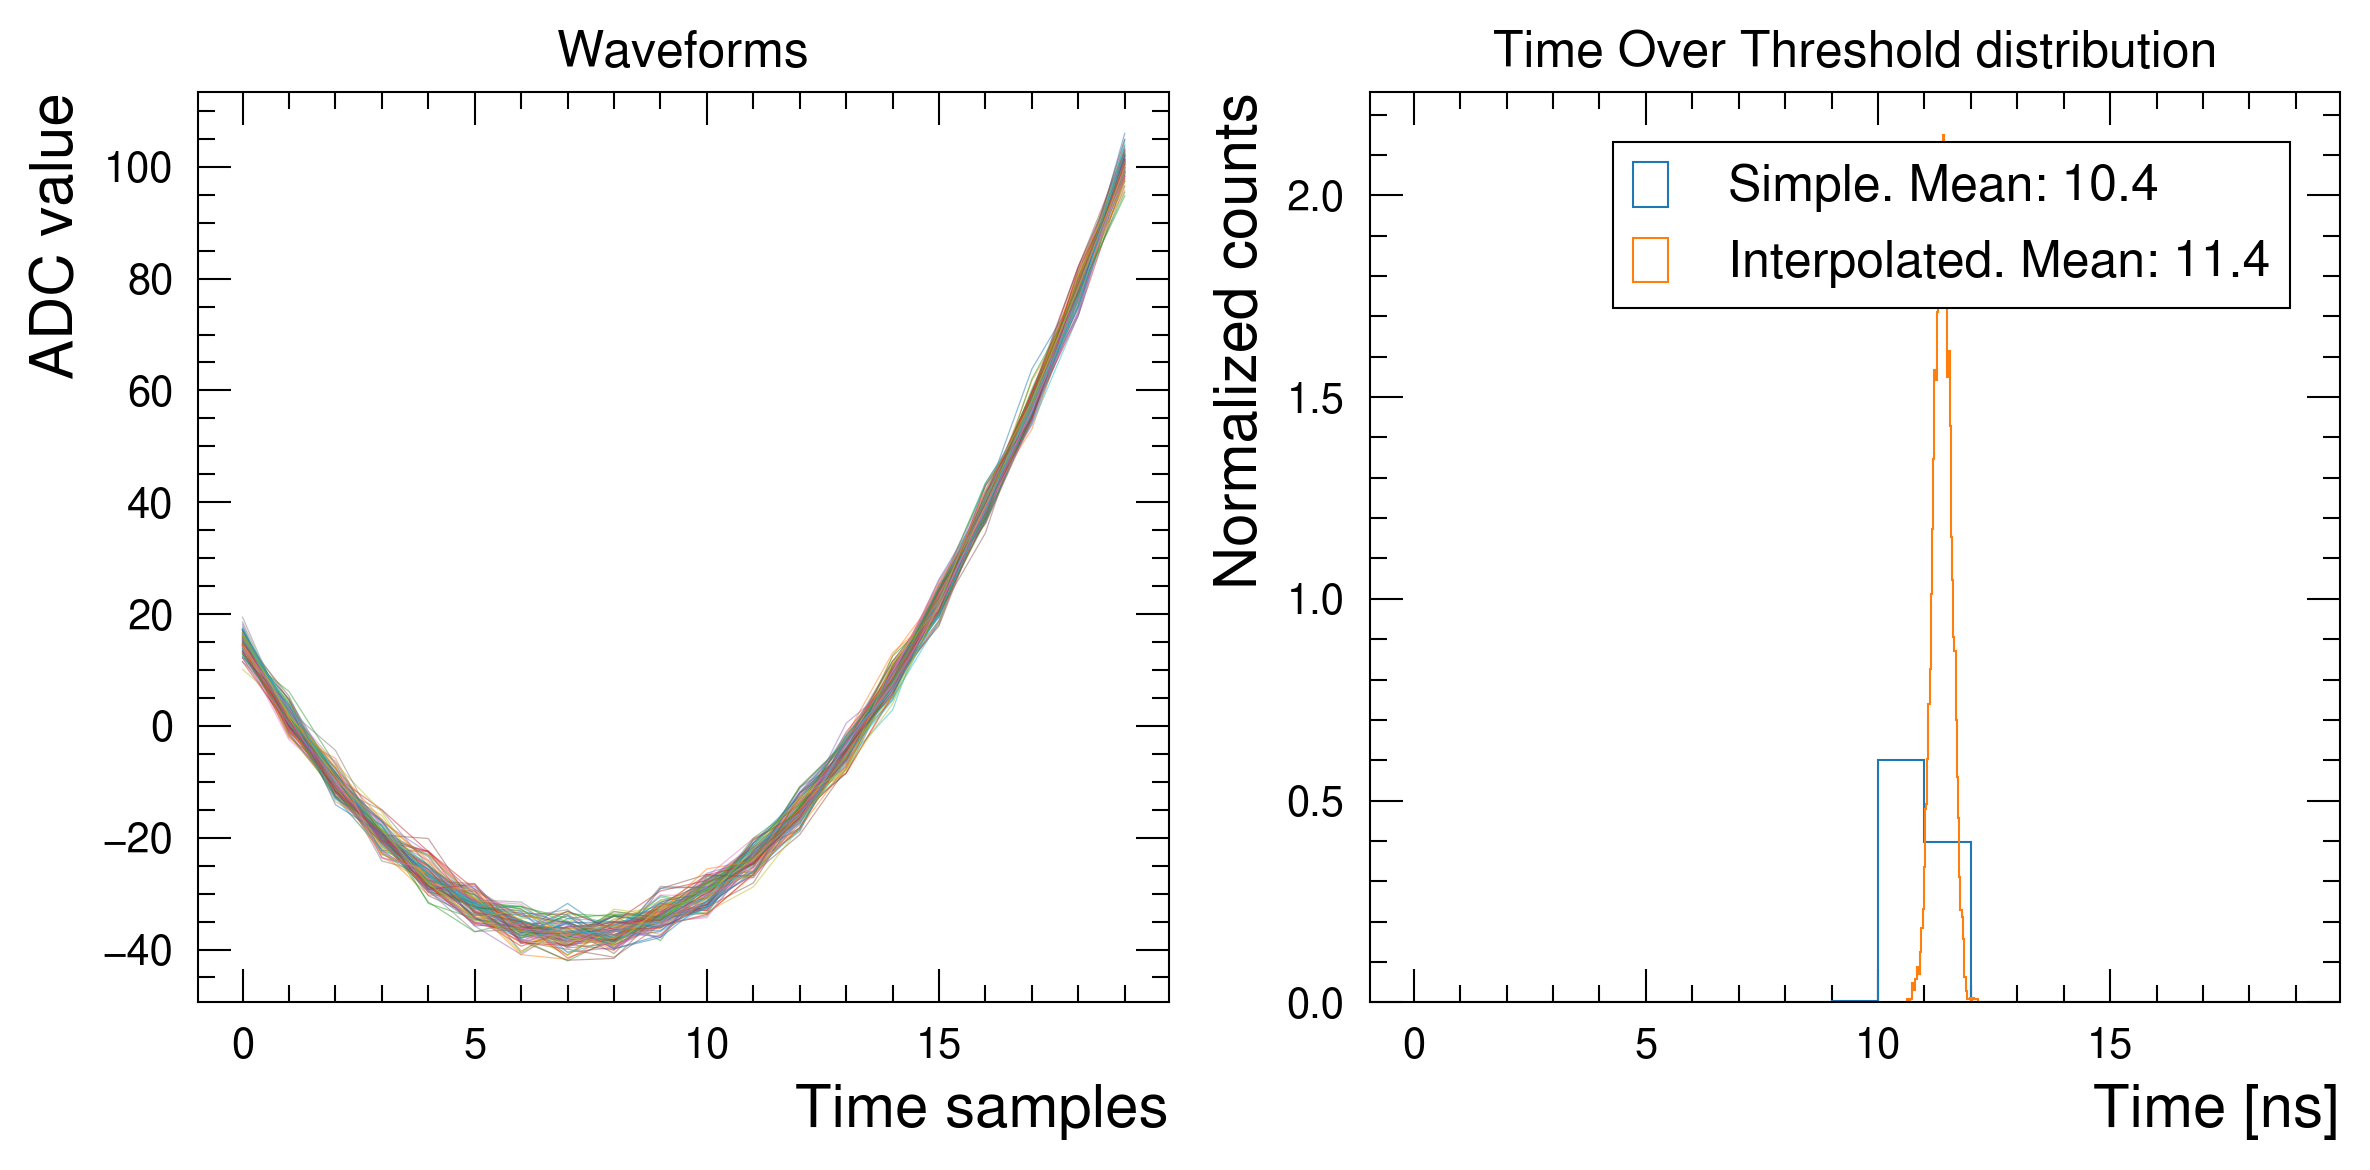

In [512]:
n_waveforms, n_samples = 10_000, 20
threshold = -5
# Generated some fake data of 10_000 waveforms of 20 samples each
# with values between -10 and 0
x = np.tile(np.arange(n_samples), n_waveforms).reshape((n_waveforms, n_samples))
noise = np.random.randn(n_waveforms, n_samples) * 2
waveforms = 5.5 * (x-10) + (x-10)**2 - 30  + noise

# Simple version of the time over threshold
samples_below_threshold = waveforms < threshold
first_items = np.argmax(samples_below_threshold, axis=1)
last_items = waveforms.shape[1] - np.argmax(samples_below_threshold[:, ::-1], axis=1) - 1
simple_tot = last_items - first_items
# Linearly interpolated version of the time over threshold
interpolated_tot = compute_time_over_threshold(waveforms, threshold)

# Plot the two time over threshold distributions
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
ax.plot(waveforms[:100, :].T, linewidth=0.3, alpha=0.5)
ax.set(title='Waveforms', xlabel='Time samples', ylabel='ADC value')

ax = axs[1]
ax.hist(simple_tot, bins=range(0, 20, 1), histtype='step', label=f'Simple. Mean: {simple_tot.mean():.1f}', density=True)
ax.hist(interpolated_tot, bins="auto", histtype='step', label=f'Interpolated. Mean: {interpolated_tot.mean():.1f}', density=True)
ax.set(title='Time Over Threshold distribution', xlabel='Time [ns]', ylabel='Normalized counts')
ax.legend()

fig.tight_layout();

It is easily visible that with a set of synthetic signals the time resolution computed with the simple sampling is different from the one computed with a linear interpolation.

# Conclusions

In this post I have tried to calculate the time over threshold in the "classical" way, but also by linearly interpolating the threshold with the points of the sampled signal to achieve a better resolution. The 1-dimensional case is fairly straight forward, but the 2-dimensional case had me think a bit about the best way to implement the solution. 

Perhaps there are better or easier ways to do this but I couldn't find anything on the internet so I had to figure it out by myself. If anyone comes up with a cleaner or better solution I will update this poit.